## Access Mooring Temperature Logger Delayed Qc (Parquet)

This Jupyter notebook demonstrates how to access and plot mooring temperature logger delayed qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/7e13b5f3-4a70-4e31-9e95-335efa491c5c).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/mooring_temperature_logger_delayed_qc.ipynb).


In [1]:
dataset_name = "mooring_temperature_logger_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 53ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 672 ms, sys: 128 ms, total: 800 ms
Wall time: 9.6 s


In [5]:
aodn_dataset.dataset.partitioning.schema

site_code: string
timestamp: string
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['PAPOR', 'CH070']
CPU times: user 86.7 ms, sys: 3.26 ms, total: 90 ms
Wall time: 83.8 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


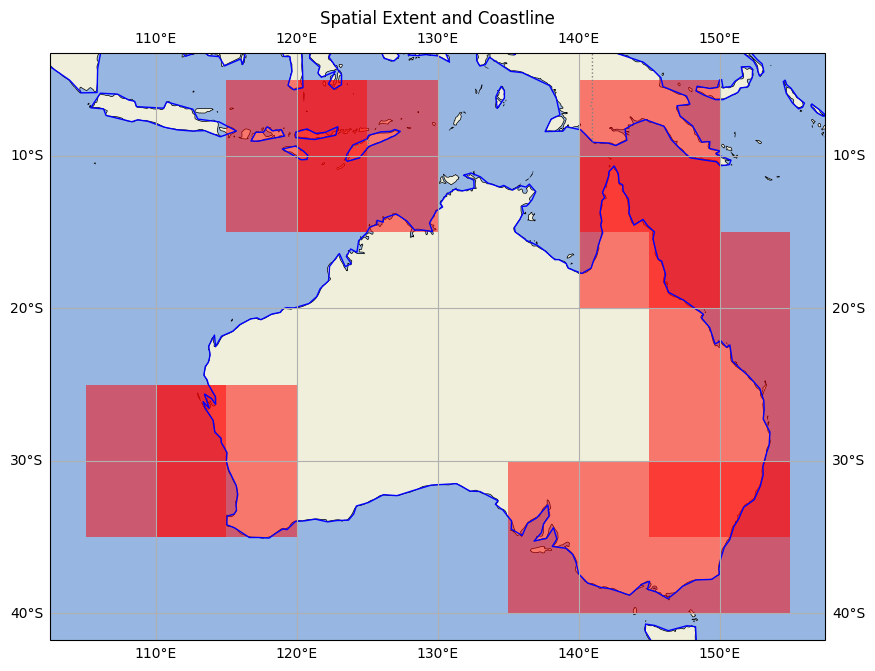

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [8]:
aodn_dataset.get_temporal_extent()

ArrowNotImplementedError: Function 'equal' has no kernel matching input types (string, int64)

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 15:25:09,589 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/mooring_temperature_logger_delayed_qc.parquet


{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0,
  'comment': 'timeOffsetPP: TIME values and time_coverage_start/end global attributes have been applied the following offset : -10 hours.'},
 'TIMESERIES': {'type': 'int32',
  'long_name': 'unique_identifier_for_each_timeseries_feature_instance_in_this_file',
  'cf_role': 'timeseries_id'},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'reference_datum': 'WGS84 coordinate reference system',
  'valid_min': -90.0,
  'valid_max': 90.0},
 'LONGITUDE': {'type': 'double',
  'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'reference_datum': 'WGS84 coordinate reference system',
  'valid_min': -180.0,
  'valid_max': 180.0},
 'NOMINAL_DEPTH': {'type': 'float',
  'standard_name': 'depth',
  'long_name': 'nominal dep

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-02', date_end='2022-12-26', lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)
df.info()

ArrowNotImplementedError: Function 'greater_equal' has no kernel matching input types (string, int32)

In [ ]:
# Download subsetted data as CSV
df.aodn.download_as_csv()

## Create a TIME and scalar/number filter

In [11]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-02', date_end='2022-12-26', scalar_filter = {'site_code': 'BMP070'} )
df.info()

ArrowNotImplementedError: Function 'greater_equal' has no kernel matching input types (string, int32)

In [12]:
df['NOMINAL_DEPTH'].unique()

NameError: name 'df' is not defined

In [13]:
import matplotlib.pyplot as plt

# Filter DataFrame where NOMINAL_DEPTH == 20
filtered_df = df[df['NOMINAL_DEPTH'] == 13]

# Plotting
fig, ax1 = plt.subplots()

# Plot TEMP on the primary y-axis (left)
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('TEMP', color=color)
ax1.plot(filtered_df['TIME'], filtered_df['TEMP'], color=color, label='TEMP')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for PRES
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('PRES', color=color)
ax2.plot(filtered_df['TIME'], filtered_df['PRES'], color=color, label='PRES')
ax2.tick_params(axis='y', labelcolor=color)

# Set a fixed number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust the number of ticks as needed

# Show legend
fig.tight_layout()
fig.legend(loc='upper left')

plt.show()

NameError: name 'df' is not defined